# Application of backboning to stackoverflow daten

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import itertools 
from collections import defaultdict
from scipy.stats import binom, pearsonr, sem

#functions written by Coscia and Neffke 
import backboning_python3_networkx2_Coscia as backboning

### Investigate data

In [2]:
# read in co-occurance data generated by Ole
#nodes = pd.read_csv("../data/node_info.csv")
coocc_table = pd.read_csv("../data/edge_list.csv")

In [3]:
#nodes.head()

In [4]:
coocc_table.head()

,tag1,tag2,co_occurance_count,tag1_count,tag2_count,total_num_obs,lift
0,visual-studio-2010,wpf,542,21596,66089,6563585,2.492516
1,enterprise-library,wpf,16,806,66089,6563585,1.971500
2,c#,wpf,37582,549189,66089,6563585,6.796260
3,visual-studio,wpf,747,38364,66089,6563585,1.933787
4,solution,wpf,5,350,66089,6563585,1.418776


In [5]:
coocc_table[(coocc_table["tag1"] == "c#") & (coocc_table["tag2"] == "visual-studio-2010")]

,tag1,tag2,co_occurance_count,tag1_count,tag2_count,total_num_obs,lift
851,c#,visual-studio-2010,5982,549189,21596,6563585,3.310491


In [6]:
coocc_table[(coocc_table["tag2"] == "c#") & (coocc_table["tag1"] == "visual-studio-2010")] # Network is undirected, but edge is not present in both directions => problem for backboning algorithm 

,tag1,tag2,co_occurance_count,tag1_count,tag2_count,total_num_obs,lift


In [7]:
#Select only the colums we need
df = coocc_table[["tag1", "tag2", "co_occurance_count"]].copy()
unique_tag1 = len(df["tag1"].unique())
unique_tag2 = len(df["tag2"].unique())
all_tags = set(list(df["tag1"].unique()) + list(df["tag2"].unique()))
print(f"# unique tag1: {unique_tag1}")
print(f"# unique tag2: {unique_tag2}")
print(f"# all tags present: {len(all_tags)}")
df.head()

# unique tag1: 8887
# unique tag2: 8477
# all tags present: 8889


,tag1,tag2,co_occurance_count
0,visual-studio-2010,wpf,542
1,enterprise-library,wpf,16
2,c#,wpf,37582
3,visual-studio,wpf,747
4,solution,wpf,5


**WARNING: It does not make any sense that number of unique tag1 != number of unique tag2!**

=> For unidirected network, each edge connecting two nodes has to show up in both directions!

In [8]:
# investigate which tags occur only once
difference_in_tags = list(set(df["tag1"].unique()) - set(df["tag2"].unique()))
print(difference_in_tags)

['n1ql', 'accessibilityservice', 'rxjs6', 'steam-web-api', 'android-architecture-navigation', 'webdriverwait', 'discord.py', 'c++98', 'google-cloud-datalab', 'magento-1.4', 'google-home', 'hamburger-menu', 'xtable', 'window-managers', 'm', 'isabelle', 'flask-socketio', 'downcast', 'nosuchelementexception', 'arcore', 'pyautogui', 'aiohttp', 'mismatch', 'kendo-ui-angular2', 'caesar-cipher', 'datastax-java-driver', 'bounce', 'dji-sdk', 'go-gorm', 'nsregularexpression', 'google-colaboratory', 'formset', 'joblib', 'material-design-lite', 'intersystems-cache', 'corda', 'qliksense', 'dblink', 'spring-integration-dsl', 'programmatically-created', 'datagridviewcolumn', 'roblox', 'cgo', 'framebuffer', 'tokbox', 'firefox-developer-tools', 'office365-apps', 'facebook-comments', 'modbus', 'sweetalert2', 'quickfix', 'biztalk-2013', 'nativescript-angular', 'hibernate-envers', 'loadrunner', 'square-connect', 'serversocket', 'minimization', 'squarespace', 'check-constraints', 'antd', 'flutter-layout', 

In [9]:
df[(df["tag1"] == "c#")].head()

,tag1,tag2,co_occurance_count
2,c#,wpf,37582
851,c#,visual-studio-2010,5982
2105,c#,enterprise-library,324


In [10]:
df[(df["tag2"] == "c#") & (df["tag1"] == "wpf")]

,tag1,tag2,co_occurance_count


## Prepare data: Alter table in a way to represent undirected network

(edge present in both directions)

In [11]:
df.head()

,tag1,tag2,co_occurance_count
0,visual-studio-2010,wpf,542
1,enterprise-library,wpf,16
2,c#,wpf,37582
3,visual-studio,wpf,747
4,solution,wpf,5


In [12]:
# find all tags possible
all_tags = set(list(df["tag1"].unique()) + list(df["tag2"].unique()))
combinations = [i for i in itertools.permutations(all_tags, r=2)]
len(combinations) #number matches the expectation (len(unique_tags)^2 - len(unique_tags))

79005432

####### create dataframe that has all combinations 
df_complete = pd.DataFrame(combinations, columns =['Tag1', 'Tag2'])
df_complete["count"] = np.nan
df_complete.head()

In [17]:
# creation of dictionary
df_dic = df.T.to_dict(orient = "dict") # this line is quite slow

In [18]:
# create two dictionaries: one having the directed edges (mapping_dic) & one to store the undirected edges (all_dic)
mapping_dic = {}
for key in df_dic.keys(): 
    mapping_dic[df_dic[key]["tag1"]] = {}
for key in df_dic.keys(): 
    mapping_dic[df_dic[key]["tag1"]][df_dic[key]["tag2"]] = df_dic[key]["co_occurance_count"]

In [19]:
all_dic = {}
for tag1 in mapping_dic.keys(): 
    for tag2 in mapping_dic[tag1].keys(): 
        all_dic[tag1] = {}
        all_dic[tag2] = {}
        
for tag1 in mapping_dic.keys(): 
    for tag2 in mapping_dic[tag1].keys():
        all_dic[tag1][tag2] = mapping_dic[tag1][tag2]
        all_dic[tag2][tag1] = mapping_dic[tag1][tag2]

In [20]:
all_dic['python']['factorial']#['python']

32

In [21]:
#df_complete = pd.DataFrame.from_dict(all_dic, orient='columns')
#df_complete.shape #fits expectation

In [65]:
tag1_ls = []
frames = []

for tag1, tag_dic in all_dic.items():
    tag1_ls.append(tag1)
    frames.append(pd.DataFrame.from_dict(tag_dic, orient='index'))

df_complete = pd.concat(frames, keys=tag1_ls)
df_complete = df_complete.reset_index().rename(columns = {"level_0" : "tag1", "level_1" : "tag2", 0: "count"})

In [66]:
df_complete.shape

(2356667, 3)

In [82]:
df_complete.tail()

,src,trg,count
2356662,powerbi-desktop,powerbi,11
2356663,powerbi-desktop,dax,3
2356664,powerbi-desktop,powerquery,1
2356665,powerbi-desktop,powerbi-embedded,2
2356666,ionic4,ionic-framework,4


In [68]:
all_dic["visual-studio-2010"]["wpf"]

542

In [69]:
df_complete = df_complete.rename(columns = {"tag1" : "src", "tag2" : "trg"})

In [77]:
df_complete[(df_complete["src"] == "visual-studio-2010") & (df_complete["trg"] == "wpf")]

,src,trg,count
0,visual-studio-2010,wpf,542


In [78]:
df_complete[(df_complete["src"] == "wpf") & (df_complete["trg"] == "visual-studio-2010")]

,src,trg,count
1256,wpf,visual-studio-2010,542


In [98]:
src_set = set(df_complete["src"])
trg_set = set(df_complete["trg"])
trg_set-src_set, len(trg_set), len(src_set) # all tags are present 

(set(), 8889, 8889)

In [100]:
src_ls = sorted([str(i) for i in list(df_complete["src"])])
trg_ls = sorted([str(i) for i in list(df_complete["trg"])])
src_ls == trg_ls, len(src_ls), len(trg_ls) # target and source list are the same

(True, 2356667, 2356667)

In [5]:
#df_complete.to_csv(path_or_buf="../data/undirected_stackoverflow_network.csv", sep='\t')

## Perform backboning 

In [6]:
table, original_nodes, original_edges = backboning.read("../data/undirected_stackoverflow_network.csv", column_of_interest = "count", undirected = True)

In [7]:
table.head()

,src,trg,nij
0,visual-studio-2010,wpf,542
1,visual-studio-2010,enterprise-library,6
2,visual-studio-2010,c#,5982
3,visual-studio-2010,visual-studio,2866
4,visual-studio-2010,solution,39


In [8]:
original_nodes, original_edges

(8889, 1178333.5)

In [9]:
import settings_tab2

measure = "noise_corrected"
network = "stackoverflow"

In [10]:
edge_table = settings_tab2.measures[measure](table, undirected = True) # backboning takes place here 

Calculating NC score...


In [11]:
edge_table.head()

,src,trg,nij,score,sdev_cij
0,visual-studio-2010,wpf,542,0.533262,0.005477
2106,enterprise-library,wpf,16,0.417976,0.058885
2360,c#,wpf,37582,0.812598,0.228932
4097,visual-studio,wpf,747,0.432409,0.013132
5338,solution,wpf,5,0.188131,0.180965


### Find appropriate threshold

from the paper [p. 429]: “common values of δ are 1.28, 1.64, and 2.32, which approximate p-values of 0.1, 0.05, and 0.01.”

In [78]:
# set test threshold
# threshold = 2.32 # can also be set even higher if whished for
threshold = 1000

In [79]:
# function from Coscia
def thresholding(table, threshold):
    """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.
    Args:
    table (pandas.DataFrame): The edge table.
    threshold (float): The minimum significance to include the edge in the backbone.

    Returns:
    The network backbone.
    """
    
    table = table.copy()
    if "sdev_cij" in table:
        return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
    else:
        return table[table["score"] > threshold][["src", "trg", "nij", "score"]]

In [80]:
def apply_thresholding(edge_table, measure, threshold): 
    
    if measure in ["maximum_spanning_tree", "doubly_stochastic"]: 
        edge_table_thresholded = edge_table.copy()
    else: 
        edge_table_thresholded = thresholding(edge_table, threshold)
    return edge_table_thresholded

In [81]:
edge_table_thresholded = apply_thresholding(edge_table, measure, threshold)

In [82]:
edge_table.shape, edge_table_thresholded.shape # remaining edges 

((1176731, 5), (13934, 4))

In [83]:
len(edge_table)-len(edge_table_thresholded) # number of dropped edges by thresholding (1.28: 265703, 1.64: 310367, 2.32: 382907)

1162797

<AxesSubplot:>

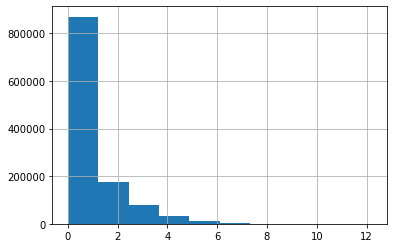

In [84]:
edge_table["nij"].map(lambda x: np.log(x)).hist()

<AxesSubplot:>

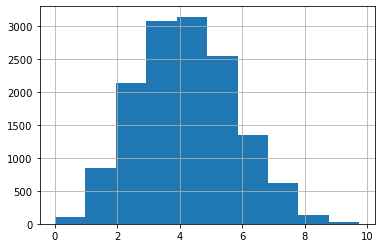

In [85]:
edge_table_thresholded["nij"].map(lambda x: np.log(x)).hist()

In [86]:
edge_table.head()

,src,trg,nij,score,sdev_cij
0,visual-studio-2010,wpf,542,0.533262,0.005477
2106,enterprise-library,wpf,16,0.417976,0.058885
2360,c#,wpf,37582,0.812598,0.228932
4097,visual-studio,wpf,747,0.432409,0.013132
5338,solution,wpf,5,0.188131,0.180965


### Apply backboning to thresholded data

In [87]:
def backbone_network(edge_table_thresholded, edge_table, table, original_nodes, original_edges): 
    
    original_nodes_thresh = len(set(edge_table_thresholded["src"]) | set(edge_table_thresholded["trg"]))
    original_edges_thresh = edge_table_thresholded.shape[0]

    print(f"Number of original nodes pre-thresholding: {original_nodes}")
    print(f"Number of original edges pre-thresholding: {int(original_edges)} \n")
    print(f"Number of original nodes post-thresholding: {original_nodes_thresh}")
    print(f"Number of original edges post-thresholding: {int(original_edges_thresh)} \n")
    
    print(f"Difference in nodes: {original_nodes-original_nodes_thresh}")
    print(f"Difference in edges: {int(original_edges-original_edges_thresh)}")
    
    G_threshold = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
    G = nx.from_pandas_edgelist(edge_table, "src", "trg")
    G_raw = nx.from_pandas_edgelist(table, "src", "trg")
    
    return G, G_threshold, G_raw

In [88]:
G, G_threshold, G_raw = backbone_network(edge_table_thresholded, edge_table, table, original_nodes, original_edges)

Number of original nodes pre-thresholding: 8889
Number of original edges pre-thresholding: 1178333 

Number of original nodes post-thresholding: 7696
Number of original edges post-thresholding: 13934 

Difference in nodes: 1193
Difference in edges: 1164399


In [ ]:
nx.draw_kamada_kawai(G_threshold, node_size = 30, edge_color = "gray", width = 0.5)

In [63]:
#nx.draw_kamada_kawai(G, node_size = 30, edge_color = "gray", width = 0.5)

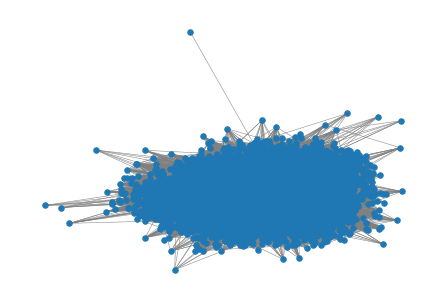

In [64]:
#nx.draw(G, node_size = 30, edge_color = "gray", width = 0.5)

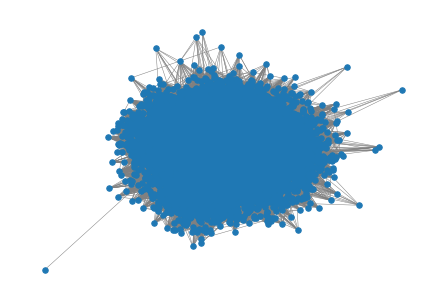

In [26]:
edge_table_thresholded.head(40)

,src,trg,nij,score
23534,datagrid,wpf,3524,0.969004
5629,vs-extensibility,vspackage,37,0.999578
7255,ef-code-first,entity-framework,2793,0.983495
392990,cmd,windows,2157,0.971150
1810188,custom-action,windows-installer,185,0.998007
212571,wcf,wcf-binding,688,0.992515
611838,visual-studio-extensions,vsix,121,0.999189
786995,silverlight,silverlight-3.0,587,0.994944
177820,managed,unmanaged,115,0.999184
1851942,cefsharp,chromium-embedded,86,0.999722


### Everything in one function

In [ ]:
table, original_nodes, original_edges = backboning.read("../data/undirected_stackoverflow_network.csv", column_of_interest = "count", undirected = True)

In [ ]:
def thresholding_and_backboning(table, threshold, original_nodes, original_edges): 
    
    """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.
    Args:
    table (pandas.DataFrame): The edge table.
    threshold (float): The minimum significance to include the edge in the backbone.

    Returns:
    The network backbone.
    """
    
    # filter for significant edges (same method/thresholding-function as Coscia et al (2017))
    table = table.copy()
    
    if "sdev_cij" in table:
        return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
    else:
        return table[table["score"] > threshold][["src", "trg", "nij", "score"]]
    
    
    # apply thresholding (same method/function as Coscia et al (2017))
    if measure in ["maximum_spanning_tree", "doubly_stochastic"]: 
        edge_table_thresholded = edge_table.copy()
    else: 
        edge_table_thresholded = thresholding(edge_table, threshold)
        
    original_nodes_thresh = len(set(edge_table_thresholded["src"]) | set(edge_table_thresholded["trg"]))
    original_edges_thresh = edge_table_thresholded.shape[0]

    print(f"Number of original nodes pre-thresholding: {original_nodes}")
    print(f"Number of original edges pre-thresholding: {int(original_edges)} \n")
    print(f"Number of original nodes post-thresholding: {original_nodes_thresh}")
    print(f"Number of original edges post-thresholding: {int(original_edges_thresh)} \n")
    
    print(f"Difference in nodes: {original_nodes-original_nodes_thresh}")
    print(f"Difference in edges: {int(original_edges-original_edges_thresh)}")
    
    G_threshold = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
    G = nx.from_pandas_edgelist(edge_table, "src", "trg")
    
    return G, G_threshold

In [ ]:
def thresholding_and_backboning(table, threshold, original_nodes, original_edges)